Text(0.5, 1.0, 'by hour')

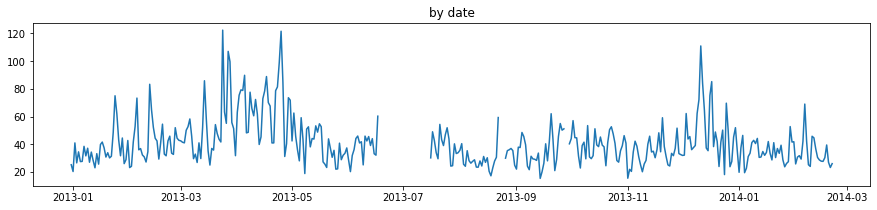

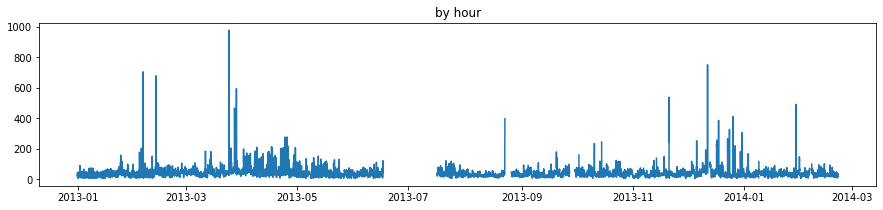

In [3]:
# load JSON
import json
import pandas as pd
 
# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
df_h = data[0:10000]

# group by date
df_d = df_h.groupby(['just_date'],squeeze=True).mean()
df_d.columns = ['_'.join(col).strip() for col in df_d.columns.values]
df_d = df_d.reset_index()
df_d.columns = ['ds','y'] # rename column

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(df_d['ds'],df_d['y'])
plt.title('by date')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


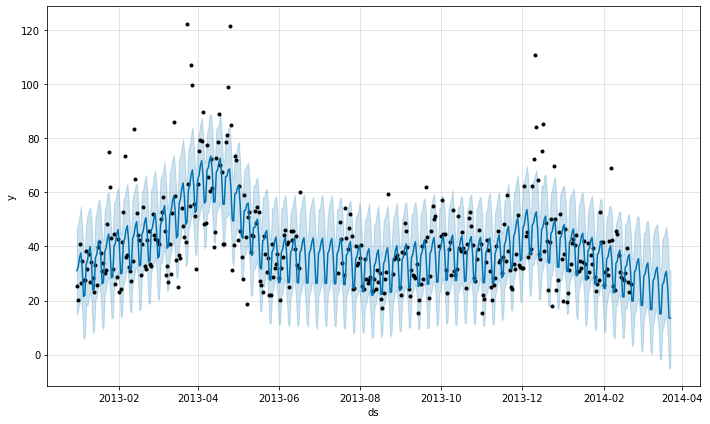

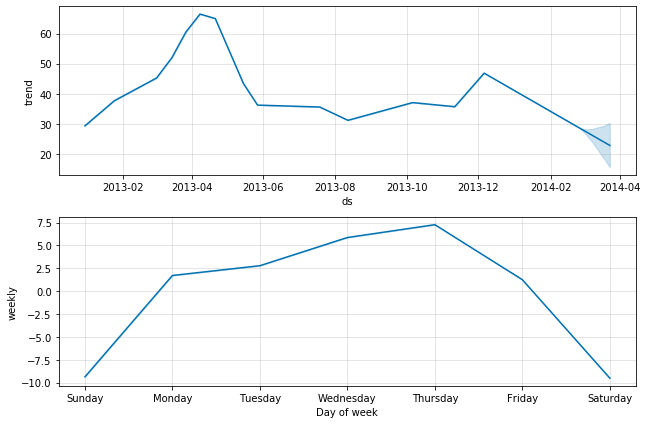

In [5]:
df = df_d
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [6]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='180 days', period='30 days', horizon ='60 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2013-07-26 00:00:00 and 2013-12-23 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-07-27,32.297639,14.607828,48.927833,24.208333,2013-07-26
1,2013-07-28,33.588509,17.004243,49.782139,24.500000,2013-07-26
2,2013-07-29,45.122261,27.643004,61.689899,40.291667,2013-07-26
3,2013-07-30,45.898621,28.590665,64.619507,33.291667,2013-07-26
4,2013-07-31,48.862682,31.923473,66.212926,33.875000,2013-07-26


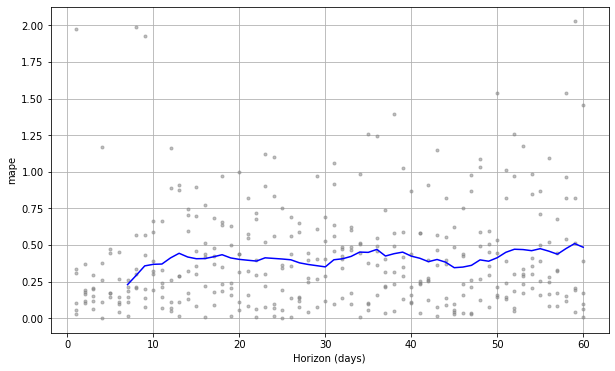

In [7]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [8]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 40.66596542807735%
SMAPE = 8.683903521501238%


In [7]:
#import pickle
#pkl_path = "franklin-d-roosevelt/PM10_m.pkl"
#with open(pkl_path, "wb") as f:
#    # Pickle the 'Prophet' model using the highest protocol available.
#    pickle.dump(m, f)

## save the dataframe
#forecast.to_pickle("franklin-d-roosevelt/PM10_forecast.pkl")
#print("*** Data Saved ***")

*** Data Saved ***


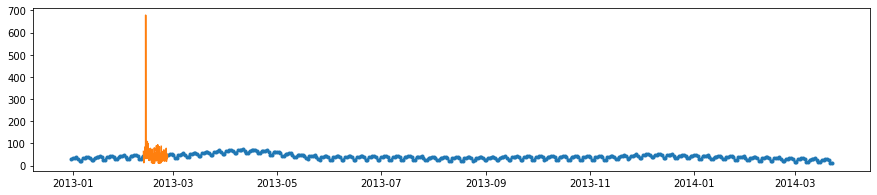

In [9]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
plt.plot(data.ds[1001:1340],data.y[1001:1340])